In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Helper class

In [ ]:
# Function to determine prime numbers:
def is_prime(n):
    if n > 2:
        i = 2
        while i ** 2 <= n:
            if n % i:
                i += 1
            else:
                return False
    elif n != 2:
        return False
    return True

class World:
    def __init__(self, csvfile):
        self.df = pd.read_csv(csvfile)
        self.cities = {}
        self.pos = self.df.iloc[:, 1:3].values
        self.city_ids = self.df.CityId.values.astype('int')
        #primes = primesfrom2to(int(max(self.city_ids)))
        self.city_ids_prime = np.array([is_prime(i) for i in self.city_ids])
    
    def plot(self, show_primes=False):
        """
        Creates a world plot, mark the north pole. Option to show primes in different collor
        """
        fig, ax = plt.subplots(figsize=(8,8))
        x = self.pos[:, 0]
        y = self.pos[:, 1]
        ax.scatter(x, y, s=0.07, c='green', alpha=0.6)

        if show_primes:
            ax.scatter(x[self.city_ids_prime], y[self.city_ids_prime], c='red', s=0.1, alpha=0.6)
        
        ax.scatter(self.pos[0,0], self.pos[0,1], c='blue', s=16)
        ax.axis('off')
        return plt.show()

In [ ]:
csvfile = '../input/cities.csv'
world = World(csvfile)

In [ ]:
world.plot()

## Create Smaller Dataset

Let's subsample cities to make it easier to play with.

In [ ]:
csv = pd.read_csv(csvfile)
city_indices = np.arange(len(csv))
np.random.shuffle(city_indices)
subset_indices = city_indices[:int(len(csv)/10)]
subset = csv.iloc[subset_indices,:]

In [ ]:
subset_csv = 'cities_subset.csv'
subset.to_csv(subset_csv, index=False)

In [ ]:
world = World(subset_csv)
world.plot()

## Route helper class

In [ ]:
from matplotlib.collections import LineCollection
from tqdm import tqdm

class Route():
    def __init__(self, world):
        # Init path with just the North Pole
        self.world = world
        self.stops = []
        self.city_ids = np.array(self.world.city_ids)
        self.cities_index = {city_id: index for index, city_id in enumerate(self.world.city_ids)}
        self.reset_visited()

    def reset_visited(self):
        self.visited = np.array([False for city_id in self.world.city_ids])
    
    def _find_nearst_unvisited_neighbors(self, city_id, num=1):
        city_index = self.cities_index[city_id]
        city_pos = self.world.pos[city_index]
        dist2 = np.sum((self.world.pos[~self.visited] - city_pos)**2, axis=1)
        if num == 1:
            candidates = [np.argmin(dist2)]
        else:
            candidates = np.argsort(dist2)
        candidate_indices = candidates[:num]
        nearst_neighbor_ids = self.city_ids[~self.visited][candidate_indices]
        nearst_neighbor_indices = [self.cities_index[_] for _ in nearst_neighbor_ids]
        return nearst_neighbor_indices
    
    def build_naive_path(self, batch_num=1):
        """
        Connects the nearst neighbors. 
        
        batch_num parameter allows connects more than one neighbors 
        at a time making this run faster, but results in longer path
        than typical greedy search.
        
        set batch_num = 1 to return to greedy nearst neighbor search.
        """
        self.add(0)
        with tqdm(total=len(self.city_ids)) as pbar:
            while 1:
                last_city_index = self.stops[-1]
                last_city_id = self.city_ids[last_city_index]
                neighbor_indices = self._find_nearst_unvisited_neighbors(last_city_id, batch_num)
                for city_index in neighbor_indices:
                    self.add(city_index)
                pbar.update(len(neighbor_indices))
                
                if np.all(self.visited):
                    break  
        self.add(0)
        
    def add(self, city_index):
        self.stops.append(city_index)
        self.visited[city_index] = True
    
    def cost(self):
        pos = self.world.pos
        dist = np.sqrt(np.sum((pos[self.stops[1:]] - pos[self.stops[:-1]])**2, axis=1))
        non_prime_10th_step_indices = ((np.argwhere(self.world.city_ids_prime[self.stops[10::10]] == False) + 1) * 10 - 1).flatten()
        dist[non_prime_10th_step_indices] *= 1.1
        return np.sum(dist)
    
    def plot(self):
        pos = self.world.pos
        lines = [[pos[index], pos[self.stops[i+1]]] for i, index in enumerate(self.stops[:-1])]
        lc = LineCollection(lines, linewidths=0.1, colors='red')
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_aspect('equal')
        ax.add_collection(lc)
        ax.autoscale()
        
    def load(self, path):
        self.stops = np.load(path)
        
    def save(self, path):
        np.save(path, self.stops)
        
    def submit(self, filename):
        df = pd.DataFrame(route.stops, columns=['city'])
        df['Path'] = df.apply(lambda x: route.world.city_ids[x.iloc[0]], axis=1).astype(int)
        df[['Path']].to_csv(filename, index=False)
        

Simple test to check the code

In [ ]:
import copy
test_world = copy.deepcopy(world)

In [ ]:
test_world.city_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_world.city_ids_prime = np.array([is_prime(i) for i in test_world.city_ids])
test_world.pos = np.array([[0, i**2] for i in range(11)])
test_route = Route(test_world)
test_route.stops = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
cost = 0
for i, stop in enumerate(test_route.stops[:-1]):
    next_stop = test_route.stops[i+1]
    d = np.sqrt(sum((test_world.pos[next_stop] - test_world.pos[stop])**2))
    if (i+1)%10 == 0 and not is_prime(stop):
        d = d * 1.1
    cost += d
assert test_route.cost() == cost, "%f != %f" % (test_route.cost(), cost)

In [ ]:
test_route.stops = []
test_route.reset_visited()
test_route.build_naive_path()
cost = 0
for i, stop in enumerate(test_route.stops[:-1]):
    next_stop = test_route.stops[i+1]
    d = np.sqrt(sum((test_world.pos[next_stop] - test_world.pos[stop])**2))
    if (i+1)%10 == 0 and not is_prime(stop):
        d = d * 1.1
    cost += d
assert test_route.cost() == cost, "%f != %f" % (test_route.cost(), cost)

## Build Naive Path (with a subset of cities)

In [ ]:
world = World(subset_csv)
route = Route(world)
route.build_naive_path()

In [ ]:
route.plot()

In [ ]:
print(route.cost())

This took 12 sec and the distance was 465318. 

When batch_num is set to greater than 1, `batch_num` number of nearst neighbors from a single stop is connected as a path, making it run faster (though it results in suboptimal path).

In [ ]:
world = World(subset_csv)
route = Route(world)
route.build_naive_path(batch_num=5)

In [ ]:
route.plot()

In [ ]:
print(route.cost())

When batch_num = 5, five nearst neighbors from a stop is selected and they are connected as a path. This only took 6 sec, but the total distance was 682082.

## Build Naive Path (with the complete cities)

kernel dies after sometime, so I made a image copy below.
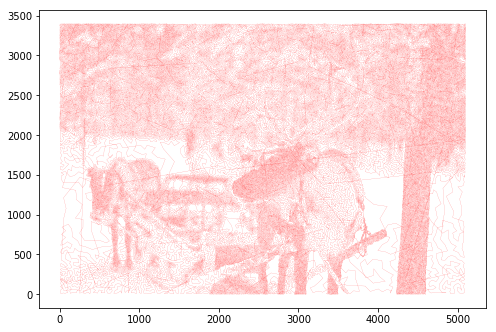

In [ ]:
world = World(csvfile)
route = Route(world)
route.build_naive_path(1)

In [ ]:
route.plot()

In [ ]:
route.cost()

This took ~20 minutes and the distance was 1812650.

In [ ]:
route.submit('submission.csv')